In [1]:
import numpy as np
import scipy as sp
import scipy.interpolate
import scipy.signal
import skimage as ski
import skimage.color, skimage.filters

import matplotlib.pyplot as plt

from itertools import pairwise

import cv2

## Load image

Load the image and make sure it is grayscale.

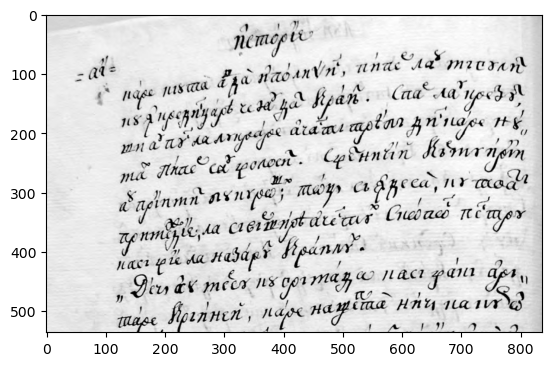

In [2]:
I = plt.imread('Rows.png')
I = ski.color.rgb2gray(I)
plt.imshow(I, cmap='gray')

Let's invert the image, so that the text is white in a black background

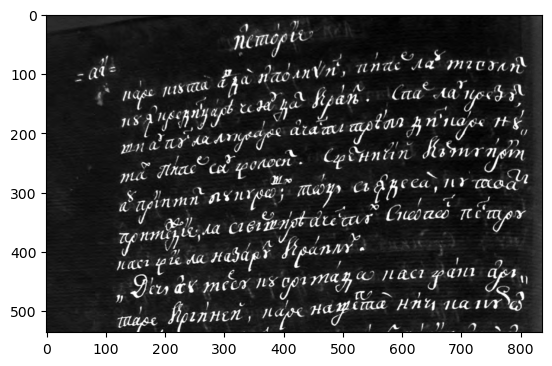

In [3]:
maxval = np.max(I)
Iinv = maxval - I
plt.imshow(Iinv, cmap='gray')

## Filter the image

We apply Gaussian filtering, with an elliptic kernel. We use a horizontal ellipse to fikter more on the rows, exploiting the *a priori* knowledge that rows are roughly horizontal.

Below is the kernel used:

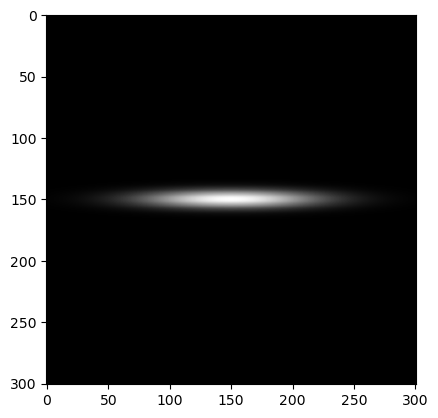

In [4]:
Idirac = np.zeros((301,301))
Idirac[150,150] = 1
Ikernel = ski.filters.gaussian(Idirac, sigma=[5, 50])
plt.imshow(Ikernel, cmap='gray')


The filtered image is:

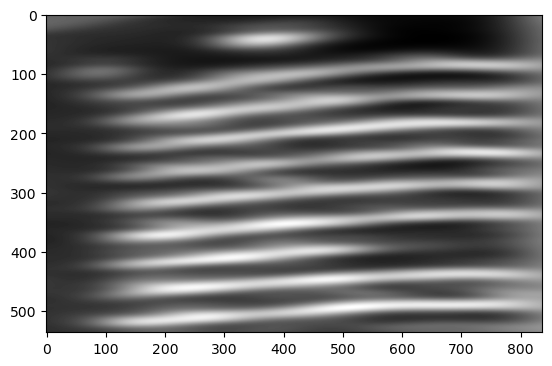

In [5]:
If = ski.filters.gaussian(Iinv, sigma=[5, 50])
plt.figure()
plt.imshow(If, cmap='gray')


## Find ridges

Select a vertical band in the middle of the page, in order to make sure we catch all the lines, and compute its histogram.

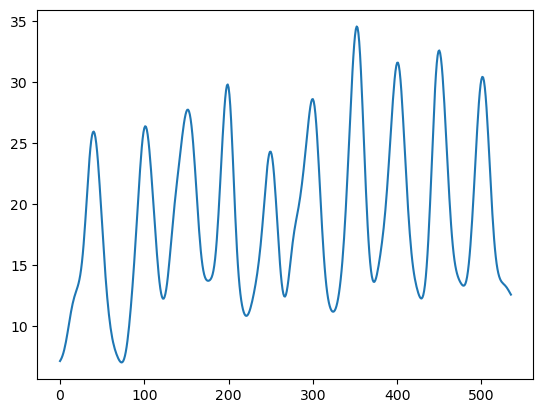

In [6]:
band_mid = int(I.shape[1] / 2)
band_halfwidth = 50

h = np.sum(If[:, band_mid-band_halfwidth:band_mid+band_halfwidth], axis=1)
plt.plot(h)

The peaks in the histogram correspond to the rows. 

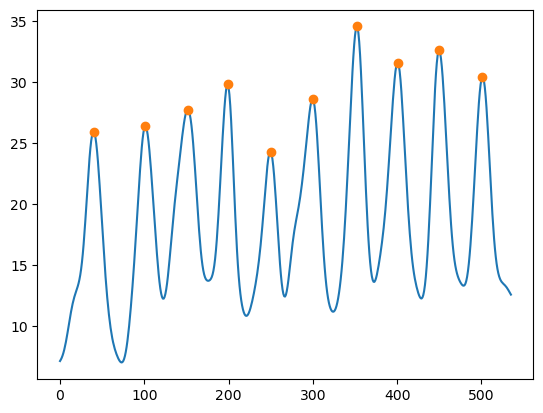

In [7]:
peaks, _ = scipy.signal.find_peaks(h)
plt.plot(h)
plt.plot(peaks, h[peaks], "o")

We define a function to follow the ridge, starting from a given point.

In [8]:
import numpy as np

def ridge_following(I, start_point, max_stride=1, stop_thresh = 0.5):
    """Follow a ridge in the image, starting from a given point, going both left and right

    Args:
        I: the image
        start_point: one point on the ridge
        max_stride (int, optional): local window where to search for the next point on the ridge. Defaults to 1.
        stop_thresh (float, optional): stop ridge when next point is smaller than (stop_thresh * max value) on the ridge

    Returns:
        a vector with the row coordinates of points on the ridge
    """

    assert len(I.shape)==2
    cols = I.shape[1]

    start_row, start_col = start_point

    # Prepare output vector, start with -1
    ridge = -1 * np.ones(cols, dtype=int)
    ridge[start_col] = start_row

    # Follow ridge to the right of start_point
    max_value = I[start_row, start_col]
    for i in range(start_col+1, cols):
        
        ridge[i] = ridge[i-1] - max_stride + np.argmax(I[ridge[i-1] - max_stride : ridge[i-1] + max_stride + 1, i])

        # Update max value
        max_value = max(max_value, I[ridge[i],i])

        # Check termination
        if I[ridge[i],i] < stop_thresh * max_value:
            ridge[i] = -1
            break

    # Follow ridge to the left of start_point
    max_value = I[start_row, start_col]
    for i in range(start_col-1, -1, -1):

        ridge[i] = ridge[i+1] - max_stride + np.argmax(I[ridge[i+1] - max_stride : ridge[i+1] + max_stride + 1, i])

        # Update max value
        max_value = max(max_value, I[ridge[i],i])

        # Check termination
        if I[ridge[i],i] < stop_thresh * max_value:
            ridge[i] = -1
            break

    return ridge


Now let's apply the ridge extraction on the image, starting on the peak points found earlier.

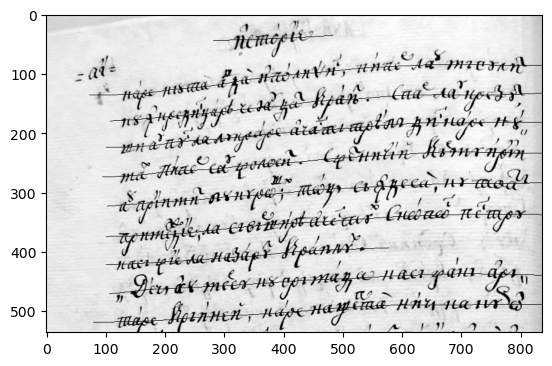

In [9]:
If2 = np.copy(I)

# Follow ridges and plot
ridges = []
for peak in peaks:

    ridge = ridge_following(If, [peak, band_mid], stop_thresh=0.5)

    # Mark on figure
    for c in range(If2.shape[1]):
        if ridge[c] != -1:
            If2[ridge[c],c] = 0

    ridges.append(ridge)

plt.figure()
plt.imshow(If2, cmap='gray')

## Spline smoothing

We can smooth and approximate ridges in different ways.

For example we can use splines of degree 1, i.e. approximate as a piecewise linear signal.

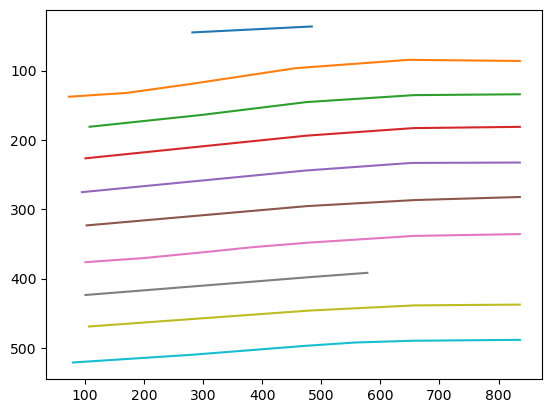

In [10]:
# Smoothing
for ridge in ridges:

    # Limit to part != -1
    x = np.array(range(I.shape[1]))
    x_actual = x[ridge != -1]    
    ridge_actual = ridge[ridge != -1]

    spl = sp.interpolate.UnivariateSpline(x_actual, ridge_actual, k=1, s=len(x)/2)

    plt.plot(x_actual, spl(x_actual))

plt.gca().invert_yaxis()
plt.show()

Zooming on one of the ridges:

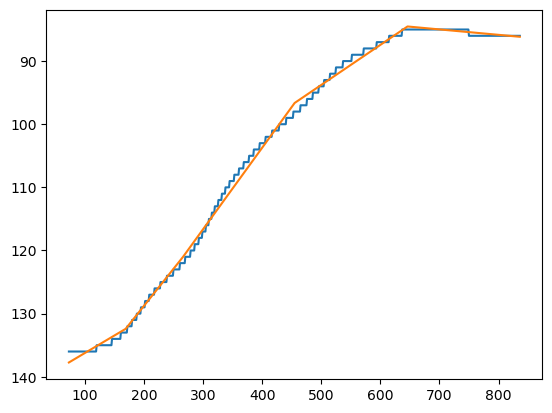

In [11]:
ridge = ridges[1]
    
# Limit to part != -1
x = np.array(range(I.shape[1]))
x_actual = x[ridge != -1]    
ridge_actual = ridge[ridge != -1]

spl = sp.interpolate.UnivariateSpline(x_actual, ridge_actual, k=1, s=len(x)/2)

plt.plot(x_actual, ridge_actual)
plt.plot(x_actual, spl(x_actual))

plt.gca().invert_yaxis()
plt.show()

## Piecewise linear approximation with fixed number of segments

We can use the Python package `pwfl`. An example on approximating one of the ridges with 4 segments:

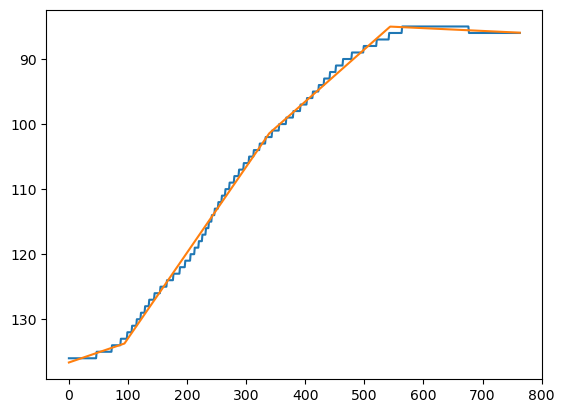

In [12]:
import pwlf 

ridge = ridges[1]
    
# Limit to part != -1
x = np.array(range(I.shape[1]))
x_actual = x[ridge != -1]    
ridge_actual = ridge[ridge != -1]

# initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x_actual, ridge_actual)

# fit the data for four line segments
#res = my_pwlf.fit(10)
res = my_pwlf.fitfast(4, pop=3)

# predict for the determined points
#xHat = np.array(range(x.shape[0]))
yHat = my_pwlf.predict(x_actual)

plt.plot(ridge_actual)
plt.plot(yHat)

plt.gca().invert_yaxis()
plt.show()

## Approximating all ridges with segments

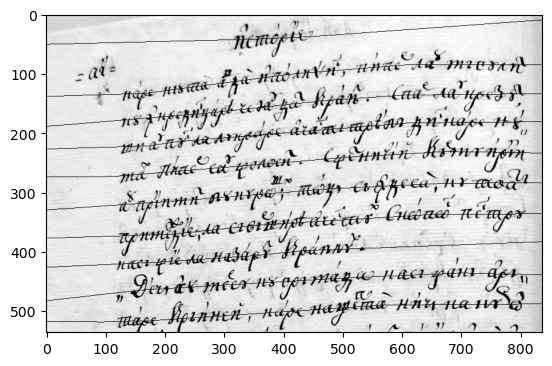

In [13]:
my_pwlfs = []
knots_all = []
knots_y_all = []
If3 = np.copy(I)

n_segments = 4
n_knots = n_segments + 3

for ridge in ridges:

    # Limit to part != -1
    x = np.array(range(I.shape[1]))
    x_actual = x[ridge != -1]    
    ridge_actual = ridge[ridge != -1]

    # initialize piecewise linear fit with your x and y data
    my_pwlf = pwlf.PiecewiseLinFit(x_actual, ridge_actual)

    # fit the data for four line segments
    knots = my_pwlf.fitfast(4, pop=3)

    # Add extremes to knots
    knots = np.insert(knots,0,0)
    knots = np.append(knots,I.shape[1]-1)
    knots_all.append(knots)
    knots_y_all.append(my_pwlf.predict(knots))

    # predict for all columns, for left edge to right edge of page
    xAll = np.array(range(I.shape[1]))
    yAll = my_pwlf.predict(xAll)

    # Mark on figure
    for c in range(If3.shape[1]):
        xval = int(yAll[c])
        xval = 0 if xval < 0 else xval
        xval = I.shape[0] if xval >= I.shape[0] else xval
        If3[xval,c] = 0

plt.figure()
plt.imshow(If3, cmap='gray')
#plt.gca().invert_yaxis()
plt.show()

Plot grid

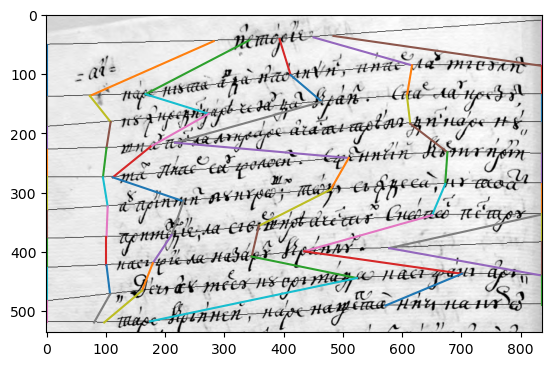

In [14]:
plt.imshow(If3, cmap='gray')

for k in range(len(knots_all)-1):
    for i in range(7):
        #plt.plot([knots_y_all[k][i], knots_y_all[k+1][i]],[knots_all[k][i], knots_all[k+1][i]])
        plt.plot([knots_all[k][i], knots_all[k+1][i]],[knots_y_all[k][i], knots_y_all[k+1][i]])
        #print([knots_all[k][i], knots_all[k+1][i]])
        #print([knots_y_all[k][i], knots_y_all[k+1][i]])
        
plt.show()

In [15]:
# Compute target coordinates
# Horizontal line
target_knots_y_all = [[knots_y[0]]*len(knots_y)  for knots_y in knots_y_all]

# According to lengths
ridge_length = []
for xs, ys in zip(knots_all, knots_y_all):
     ridge_length.append(sum([np.linalg.norm(np.array(p2)-np.array(p1)) for p1, p2 in pairwise(zip(xs, ys))]))
ridge_length

ridge_cum_length = []
for xs, ys in zip(knots_all, knots_y_all):
     # Prepend 0, gets lots because of pairwise()
     ridge_cum_length.append(np.cumsum([0] + [np.linalg.norm(np.array(p2)-np.array(p1)) for p1, p2 in pairwise(zip(xs, ys))]))
ridge_cum_length 

target_length = I.shape[1]
target_knots_x_all = [cumlen / totallen * target_length for cumlen,totallen in zip(ridge_cum_length, ridge_length)]
target_knots_x_all



[array([  0.        , 282.01183207, 342.01434954, 393.03828891,
        450.48541418, 484.17761261, 837.        ]),
 array([  0.        ,  72.87275319, 166.55556112, 413.03632906,
        618.10092217, 837.        , 837.        ]),
 array([  0.        , 108.1885786 , 273.94409362, 465.67959304,
        609.36684621, 837.        , 837.        ]),
 array([  0.        , 100.93329291, 175.11824225, 217.03060213,
        614.83170257, 837.        , 837.        ]),
 array([  0.        ,  94.9278427 , 111.51573894, 510.69299314,
        677.38809435, 837.        , 837.        ]),
 array([  0.        , 103.17302476, 231.38804574, 480.45418816,
        673.6652702 , 837.        , 837.        ]),
 array([  0.        , 100.99573595, 210.84109418, 358.82312841,
        651.49612777, 837.        , 837.        ]),
 array([  0.        , 101.06821731, 179.22313771, 346.43612128,
        435.61392982, 578.90252956, 837.        ]),
 array([  0.        , 107.57090376, 161.85902342, 524.75722502,
        

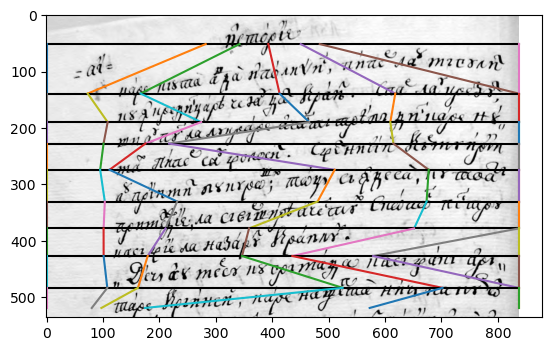

In [16]:
If4 = np.copy(I)
plt.imshow(If4, cmap='gray')

for k in range(len(target_knots_x_all)-1):
    plt.plot([0, If4.shape[1]],[target_knots_y_all[k][0], target_knots_y_all[k][0]], 'k')
    for i in range(7):
        #plt.plot([knots_y_all[k][i], knots_y_all[k+1][i]],[knots_all[k][i], knots_all[k+1][i]])
        plt.plot([target_knots_x_all[k][i], target_knots_x_all[k+1][i]],[target_knots_y_all[k][i], target_knots_y_all[k+1][i]])
        #print([knots_all[k][i], knots_all[k+1][i]])
        #print([knots_y_all[k][i], knots_y_all[k+1][i]])
        
plt.show()

## Rectify

Compute target points for all rectangles defined by the knots

TODO

In [32]:
# Rectify a box
def rect_box_image(points_src, points_dst, Iold):

    Inew = Iold.copy()

    persp_mat = cv2.getPerspectiveTransform(points_src, points_dst, cv2.DECOMP_LU)
    Ipersp = cv2.warpPerspective(Iold, persp_mat, Inew.shape[1::-1], flags=cv2.INTER_LINEAR)

    return Ipersp    


In [44]:
# for (itop, top), (ibottom, bottom) in pairwise(enumerate(target_knots_x_all)):
#     for topleft, topright in pairwise()
target_boxes = []
for k in range(len(target_knots_x_all)-1):
    # toprow_pairs = pairwise(target_knots_x_all[k])
    # botrow_pairs = pairwise(target_knots_x_all[k+1])
    #for top_left, top_right in pairwise(target_knots_x_all[k])
    for i in range(6):
        x_top_left  = target_knots_x_all[k][i]
        x_top_right = target_knots_x_all[k][i+1]
        x_bot_left  = target_knots_x_all[k+1][i]
        x_bot_right = target_knots_x_all[k+1][i+1]

        y_top_left  = target_knots_y_all[k][i]
        y_top_right = target_knots_y_all[k][i+1]
        y_bot_left  = target_knots_y_all[k+1][i]
        y_bot_right = target_knots_y_all[k+1][i+1]

        # Pair coordinates
        target_boxes.append([ [x_top_left, y_top_left], [x_top_right, y_top_right], [x_bot_right, y_bot_right], [x_bot_left, y_bot_left]])

source_boxes = []
for k in range(len(knots_all)-1):
    # toprow_pairs = pairwise(target_knots_x_all[k])
    # botrow_pairs = pairwise(target_knots_x_all[k+1])
    #for top_left, top_right in pairwise(target_knots_x_all[k])
    for i in range(6):
        x_top_left  = knots_all[k][i]
        x_top_right = knots_all[k][i+1]
        x_bot_left  = knots_all[k+1][i]
        x_bot_right = knots_all[k+1][i+1]

        y_top_left  = knots_y_all[k][i]
        y_top_right = knots_y_all[k][i+1]
        y_bot_left  = knots_y_all[k+1][i]
        y_bot_right = knots_y_all[k+1][i+1]

        # Pair coordinates
        source_boxes.append([ [x_top_left, y_top_left], [x_top_right, y_top_right], [x_bot_right, y_bot_right], [x_bot_left, y_bot_left] ])


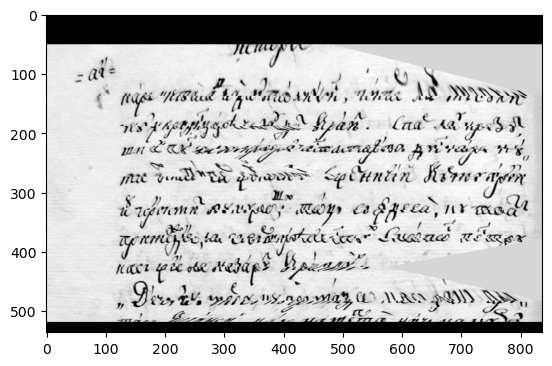

In [45]:
# Prepare new matrix
I5 = np.zeros_like(I)

for src_box, dst_box in zip(source_boxes, target_boxes):
    Iwarped = rect_box_image(np.array(src_box, dtype = "float32"), np.array(dst_box, dtype = "float32"), I) 
        
    # Create mask for the triangle we want to transform
    # mask = np.zeros(dst_img_cropped.shape, dtype = np.uint8)
    # cv2.fillConvexPoly(mask, np.int32(dst_triangle_cropped), (1.0, 1.0, 1.0), 16, 0);

    # # Delete all existing pixels at given mask
    # dst_img_cropped*=1-mask
    # # Add new pixels to masked area
    # dst_img_cropped+=dst_img_warped*mask    

    mask = np.zeros_like(Iwarped, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_box), (1.0, 1.0, 1.0), 16, 0);

    # Delete all existing pixels at given mask
    I5*=1-mask
    # Add new pixels to masked area
    I5+=Iwarped*mask    

plt.imshow(I5, cmap='gray')
plt.show()

In [41]:
len(target_knots_x_all)
target_knots_x_all[0]
#target_knots_y_all[0]

array([  0.        , 282.01183207, 342.01434954, 393.03828891,
       450.48541418, 484.17761261, 837.        ])

In [42]:
source_boxes[0]



[[0.0, 51.12635706859706],
 [282.0, 44.19487653455106],
 [0.0, 138.89925053884733],
 [73.0, 136.64725592989137]]

In [43]:
source_boxes[1]

[[282.0, 44.19487653455106],
 [341.99999999820716, 42.72009344224491],
 [73.0, 136.64725592989137],
 [166.8463922275474, 133.75216593857078]]